# Anomaly Detection in Networks

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline

## Generating artificial networks and node features
This section is a demonstration of how to generate artificial networks and node features. Please to put all python scripts implementing the tool functions under the same directory of this notebook.

In [ ]:
from utils import generate_null_models, get_parameters
from generator import ER_generator, draw_anomalies
from basic_test import basic_features
from com_detection import community_detection
from spectral_localisation import spectral_features
from NetEMD import NetEMD_features
from path_finder import path_features

Set meta-parameters for network generation

In [ ]:
num_models = 20
num_nodes = 1000
num_basic_mc_samples = 500
num_references = 10
num_null_models = 60

Set 2 important parameters ```(p, w)```. ```p``` determines the edge density of the network, ```1-w``` is the under boundary of weight of the added anomaly edges.
Here all chosen ```(p, w)``` must satisfy the detectability constraints (see equations (11)-(15) in the paper).

In [ ]:
ps = np.linspace(0.001, 0.05, 50)
ws = np.linspace(0.0, 0.01, 11)
candidate_parameters = get_parameters(num_nodes, ps, ws)
num_cand_param = len(candidate_parameters)

Generate ```num_models``` models with randomly chosen parameters ```(p, w)```.

In [ ]:
for model_id in range(4, num_models):
    p, w = candidate_parameters[np.random.choice(range(num_cand_param))]
    logging.info("Computing {}-th/{} model (p={:.3f}, w={:.3f})".format(model_id, num_models, p, w))
    graph = ER_generator(n=num_nodes, p=p, seed=None)
    graph = draw_anomalies(graph, w=1-w)
    logging.info("\n\nGenerating null models\n\n")
    _, references = generate_null_models(graph, num_models=num_references, min_size=20)
    null_samples_whole, null_samples = generate_null_models(graph, num_models=num_null_models, min_size=20)
    logging.info("\n\nGenerating NetEMD features\n\n")
    graph = NetEMD_features(graph, references, null_samples, num_references=num_references, num_samples=num_null_models)
    logging.info("\n\nGenerating basic features\n\n")
    graph = basic_features(graph, num_samples=num_basic_mc_samples)
    logging.info("\n\nGenerating community features\n\n")
    graph = community_detection(graph, null_samples, num_samples=20)
    logging.info("\n\nGenerating spectral features\n\n")
    graph = spectral_features(graph, null_samples, num_samples=num_null_models)
    logging.info("\n\nGenerating path features\n\n")
    graph = path_features(graph, null_samples_whole, num_samples=num_null_models)
    features = set()
    for node in graph.nodes():
        features |= set(graph.node[node].keys())
    # features.remove('type')
    logging.info("\n\nComposing DataFrame\n\n")
    X = pd.DataFrame.from_dict(dict(graph.nodes(data=True, default=0)), orient='index')
    X.fillna(0, inplace=True)
    X.replace([np.inf, -np.inf], 0, inplace=True)
    logging.info("\n\nWriting to local file\n\n")
    X.to_csv('./data/Network_p_{:.3f}_w_{:.3f}_{}.csv'.format(p, w, model_id))

__Discussion__:

In the paper, the authors test the model trained on the training set generated a specific parameter on the testing set generated by the same parameter. However, in pratice, we can never know how the testing network is generated. To overcome this problem, we generate networks with random parameters and hide this information during the whole procedure, which means we know nothing about the parameter neither on the training set nor the testing set.

## Running Machine Learning algorithms on generated networks

In [2]:
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from utils import precision_recall, average_precision

Load generated graph data from local files. This files are the node attribute values of some artificial networks. Attributes are the features recommended in the article.

In [3]:
# list all data files
data_path = './data/'
os.listdir(data_path)

['Network_p_0.018_w_0.008_11.csv',
 'Network_p_0.028_w_0.000_13.csv',
 'Network_p_0.009_w_0.003_0.csv',
 'Network_p_0.020_w_0.006_7.csv',
 'Network_p_0.005_w_0.001_9.csv',
 'Network_p_0.023_w_0.007_12.csv',
 'Network_p_0.036_w_0.003_8.csv',
 'Network_p_0.034_w_0.003_5.csv',
 'Network_p_0.008_w_0.007_1.csv',
 'Network_p_0.016_w_0.002_3.csv',
 'Network_p_0.007_w_0.010_2.csv',
 'Network_p_0.011_w_0.001_10.csv',
 'Network_p_0.025_w_0.001_4.csv',
 'Network_p_0.010_w_0.005_6.csv']

load .csv files to data frames

In [4]:
data_path = './data/'
data = []
for data_file in os.listdir(data_path):
    data_file_path = os.path.join(data_path, data_file)
    X = pd.read_csv(data_file_path, index_col=0)
    X['type'] = (X['type']!='0').astype(int)
    data.append(X)

Define some tool functions for data preprocessing.

In [5]:
def concatenate_XY(Xs, Ys):
    """Concatenates DataFrame or Series.
    """
    features = Xs[0].columns
    X = pd.DataFrame(columns=features)
    Y = pd.Series(name='type')
    for X_, Y_ in zip(Xs, Ys):
        X = pd.concat([X, X_], axis=0, ignore_index=True, sort=True)
        Y = Y.append(Y_, ignore_index=True)
    return X, Y

In [6]:
def split_train_test(data, test_size=0.3, mix_all=True, select_features=None):
    """Splits data into training set and testing set.
    If mix_all is True, all node features (rows) of different
    networks are mixed and splited. Otherwise, some networks
    are kept entirely for testing purpose.
    """
    Ys = [X['type'] for X in data]
    Xs = [X.drop('type', axis=1) for X in data]
    if select_features is not None:
        Xs = [X.loc[:, select_features] for X in Xs]
    if mix_all:
        X, Y = concatenate_XY(Xs, Ys)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    else:
        # keep complete graph for test
        num_test_graph = max(1, int(len(data)*test_size))
        test_indice = np.random.choice(range(len(data)), size=num_test_graph, replace=False)
        Xs_train = [X for i, X in enumerate(Xs) if i not in test_indice]
        Ys_train = [Y for i, Y in enumerate(Ys) if i not in test_indice]
        X_train, Y_train = concatenate_XY(Xs_train, Ys_train)
        X_test = [X for i, X in enumerate(Xs) if i in test_indice]
        Y_test = [Y for i, Y in enumerate(Ys) if i in test_indice]
    return X_train, X_test, Y_train, Y_test

In [58]:
def precision_recall(preds, labels, *sample_sizes):
    """Computes the precision, recall and F1-score for a prediciton, for different sample sizes.
    """
    sorted_label_pred = sorted(zip(labels, preds), key=lambda x: x[1], reverse=True)
    sorted_labels = np.array([l for l, p in sorted_label_pred])
    num_anomalies = np.sum(labels)
    precs = []
    recs = []
    f1s = []
    for sample_size in sample_sizes:
        num_anormaly_samples = np.sum(sorted_labels[:sample_size])
        prec = num_anormaly_samples / sample_size
        rec = num_anormaly_samples / num_anomalies
        f1 = 0 if prec+rec==0 else 2 * prec * rec / (prec + rec)
        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)
    if len(recs) == 1:
        return precs[0], recs[0], f1s[0]
    else:
        return precs, recs, f1s

def average_precision(preds, labels):
    sample_sizes = list(range(1, len(labels)+1))
    precs, recs, _ = precision_recall(preds, labels, *sample_sizes)
    avg_p = 0
    for i in range(len(precs)-1):
        p, r = precs[i], recs[i]
        r_next = recs[i+1]
        avg_p += p * (r_next - r)
    return avg_p

## Feature Sum


The feature sum method sums simply the values of different features. However, as different features may have very different scales, we also allow normalizing each feature by a MinMaxScaler before summing them up.

In [8]:
def feature_sum(X, normalize=False):
    """Sum features of each node of X.
    If normalize is True, scaling before summing.
    """
    if normalize:
        X_ = X.copy()
        X_min = X_.min(axis=0)
        X_max = X_.max(axis=0)
        X_scale = X_max - X_min
        X_ = (X_ - X_min) / X_scale
        return X_.sum(axis=1)
    return X.sum(axis=1)

#### Load dataset for feature sum

__Discussion__:

Feature sum method relies on the ranking of the sum of features, so there is no need to do train-test-split.

In [9]:
X, _, Y, _ = split_train_test(data, test_size=0)

In [10]:
X.shape, Y.shape

((14000, 129), (14000,))

#### Feature sum without normalization

Prediction by feature sum, and then compute the precision, recall, F1-score for different sample sizes.

In [11]:
pred_fs = feature_sum(X, normalize=False)

sample_sizes = [8, 16, 32, 64, 128, 256, 512, 1014]
precs, recs, f1 = precision_recall(pred_fs, Y, *sample_sizes)

In [13]:
print("Total number of samples: {}\n".format(len(Y)))
print("{}\t{}\t{}\t{}".format('samples', 'precision', 'recall', 'f1_score'))
print('-'*40)
for samples, prec, rec, f_1 in zip(sample_sizes, precs, recs, f1):
    print('{}\t{:.3f}\t\t{:.3f}\t{:.3f}'.format(samples, prec, rec, f_1))

Total number of samples: 14000

samples	precision	recall	f1_score
----------------------------------------
8	1.000		0.004	0.008
16	1.000		0.008	0.016
32	1.000		0.016	0.031
64	0.969		0.031	0.060
128	0.836		0.053	0.100
256	0.781		0.100	0.177
512	0.574		0.146	0.233
1014	0.373		0.188	0.250


In [14]:
avg_prec = average_precision(pred_fs, Y)
avg_prec

0.30364295448713247

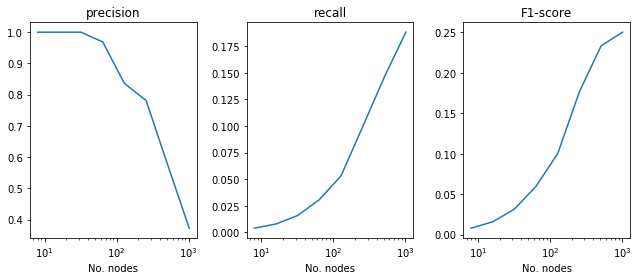

In [15]:
plt.figure(figsize=(9, 4))

plt.subplot(131)
plt.plot(sample_sizes, precs)
plt.xscale('log')
plt.title("precision")
plt.xlabel('No. nodes')

plt.subplot(132)
plt.plot(sample_sizes, recs)
plt.xscale('log')
plt.title("recall")
plt.xlabel('No. nodes')

plt.subplot(133)
plt.plot(sample_sizes, f1)
plt.xscale('log')
plt.title("F1-score")
plt.xlabel('No. nodes')

plt.tight_layout()

#### Feature sum with normalization
In this part, we normalize the features to avoid difference of scales of different features.

In [16]:
pred_fs_norm = feature_sum(X, normalize=True)

In [17]:
sample_sizes = [8, 16, 32, 64, 128, 256]
precs, recs, f1 = precision_recall(pred_fs_norm, Y, *sample_sizes)

In [19]:
print("Total number of samples: {}\n".format(len(Y)))
print("{}\t{}\t{}\t{}".format('samples', 'precision', 'recall', 'f1_score'))
print('-'*40)
for samples, prec, rec, f_1 in zip(sample_sizes, precs, recs, f1):
    print('{}\t{:.3f}\t\t{:.3f}\t{:.3f}'.format(samples, prec, rec, f_1))

Total number of samples: 14000

samples	precision	recall	f1_score
----------------------------------------
8	1.000		0.004	0.008
16	1.000		0.008	0.016
32	0.969		0.015	0.030
64	0.953		0.030	0.059
128	0.945		0.060	0.113
256	0.910		0.116	0.206


In [20]:
avg_prec = average_precision(pred_fs, Y)
avg_prec

0.30364295448713247

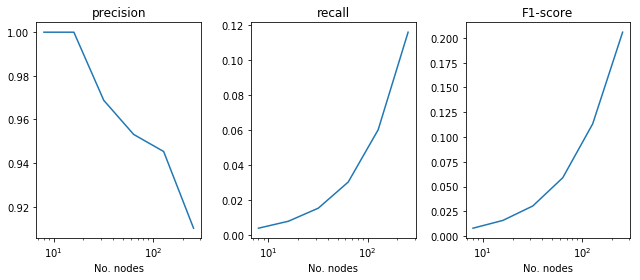

In [21]:
plt.figure(figsize=(9, 4))

plt.subplot(131)
plt.plot(sample_sizes, precs)
plt.xscale('log')
plt.title("precision")
plt.xlabel('No. nodes')

plt.subplot(132)
plt.plot(sample_sizes, recs)
plt.xscale('log')
plt.title("recall")
plt.xlabel('No. nodes')

plt.subplot(133)
plt.plot(sample_sizes, f1)
plt.xscale('log')
plt.title("F1-score")
plt.xlabel('No. nodes')

plt.tight_layout()

# Random Forest

#### Load dataset and split for Random Forest
We mix all rows (each row represents a feature vector of a node) of all networks together by setting ```max_all=True```, and then split them.

In [22]:
X_train, X_test, Y_train, Y_test = split_train_test(data, test_size=0.3, mix_all=True)

In [23]:
X_train.shape, X_test.shape

((9800, 129), (4200, 129))

In [24]:
print("n_est \t avrage precision")
for n_estimators in [10, 20, 50, 100, 150]:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_features='auto', n_jobs=-1)
    rf.fit(X_train, Y_train)
    pred_rf = rf.predict_proba(X_test)[:, 1]
    avg_prec = average_precision(pred_rf, Y_test)
    print(n_estimators, '\t', avg_prec)

n_est 	 avrage precision
10 	 0.6266256969052452
20 	 0.6321439842680457
50 	 0.6516100368801708
100 	 0.6573687806863917
150 	 0.6556913443931857


__Discussion__:

By running a cross-validation, we find that ```n_estimators=100``` gives the best performance. We will choose this as the default model for the following work.

In [25]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Predicition, Calculate precision, recall, F1-score

In [26]:
pred_rf = rf.predict_proba(X_test)[:, 1]

sample_sizes = [8, 16, 32, 64, 128, 256, 512]
precs, recs, f1 = precision_recall(pred_rf, Y_test, *sample_sizes)

In [27]:
print("Total number of samples: {}\n".format(len(Y_test)))
print("{}\t{}\t{}\t{}".format('samples', 'precision', 'recall', 'f1_score'))
print('-'*40)
for samples, prec, rec, f_1 in zip(sample_sizes, precs, recs, f1):
    print('{}\t{:.3f}\t\t{:.3f}\t{:.3f}'.format(samples, prec, rec, f_1))

Total number of samples: 4200

samples	precision	recall	f1_score
----------------------------------------
8	1.000		0.012	0.024
16	1.000		0.025	0.048
32	1.000		0.050	0.094
64	1.000		0.099	0.180
128	1.000		0.198	0.331
256	0.898		0.356	0.510
512	0.648		0.514	0.573


In [28]:
avg_prec = average_precision(pred_rf, Y_test)
avg_prec

0.6580127625540861

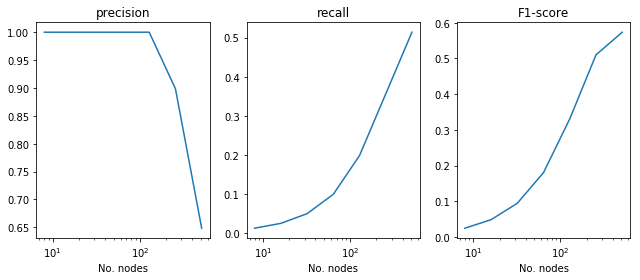

In [29]:
plt.figure(figsize=(9, 4))

plt.subplot(131)
plt.plot(sample_sizes, precs)
plt.xscale('log')
plt.title("precision")
plt.xlabel('No. nodes')

plt.subplot(132)
plt.plot(sample_sizes, recs)
plt.xscale('log')
plt.title("recall")
plt.xlabel('No. nodes')

plt.subplot(133)
plt.plot(sample_sizes, f1)
plt.xscale('log')
plt.title("F1-score")
plt.xlabel('No. nodes')

plt.tight_layout()

### Feature selection

List all features

In [30]:
features = list(X_train.columns)
print(features)

['NetEMD_comb_1', 'NetEMD_comb_2', 'NetEMD_lower_1', 'NetEMD_lower_2', 'NetEMD_rw_1', 'NetEMD_rw_2', 'NetEMD_upper_1', 'NetEMD_upper_2', 'comb_abs90', 'comb_absolute_value', 'comb_exp_1', 'comb_exp_2', 'comb_exp_3', 'comb_exp_4', 'comb_ipr90', 'comb_ipr_1', 'comb_ipr_2', 'comb_ipr_3', 'comb_ipr_4', 'comb_sign_equal_1', 'comb_sign_equal_2', 'comb_sign_stat_1', 'comb_sign_stat_2', 'degree_std', 'first_density', 'first_strength', 'gaw10_score', 'gaw20_score', 'gaw_score', 'in_out_strength_1', 'in_out_strength_2', 'in_strength_1', 'in_strength_2', 'lower_abs90', 'lower_absolute_value', 'lower_exp_1', 'lower_exp_2', 'lower_exp_3', 'lower_exp_4', 'lower_ipr90', 'lower_ipr_1', 'lower_ipr_2', 'lower_ipr_3', 'lower_ipr_4', 'lower_sign_equal_1', 'lower_sign_equal_2', 'lower_sign_stat_1', 'lower_sign_stat_2', 'motif_10_1', 'motif_10_2', 'motif_11_1', 'motif_11_2', 'motif_12_1', 'motif_12_2', 'motif_13_1', 'motif_13_2', 'motif_14_1', 'motif_14_2', 'motif_15_1', 'motif_15_2', 'motif_16_1', 'motif_1

According to the way by which they are generated, 129 features are divided in 5 categories: Localise, NetEMD, Basic, Path, Community Density.

In [31]:
categories_features = {
    "Localise": set(['comb_abs90', 'comb_absolute_value', 'comb_exp_1', 'comb_exp_2', 
                     'comb_exp_3', 'comb_exp_4', 'comb_ipr90', 'comb_ipr_1', 'comb_ipr_2', 
                     'comb_ipr_3', 'comb_ipr_4', 'comb_sign_equal_1', 'comb_sign_equal_2', 
                     'comb_sign_stat_1', 'comb_sign_stat_2', 'lower_abs90', 'lower_absolute_value', 
                     'lower_exp_1', 'lower_exp_2', 'lower_exp_3', 'lower_exp_4', 'lower_ipr90', 
                     'lower_ipr_1', 'lower_ipr_2', 'lower_ipr_3', 'lower_ipr_4', 'lower_sign_equal_1', 
                     'lower_sign_equal_2', 'lower_sign_stat_1', 'lower_sign_stat_2', 'rw_abs90', 
                     'rw_absolute_value', 'rw_exp_1', 'rw_exp_2', 'rw_exp_3', 'rw_exp_4', 'rw_ipr90', 
                     'rw_ipr_1', 'rw_ipr_2', 'rw_ipr_3', 'rw_ipr_4', 'rw_sign_equal_1', 'rw_sign_equal_2', 
                     'rw_sign_stat_1', 'rw_sign_stat_2', 'upper_abs90', 'upper_absolute_value', 
                     'upper_exp_1', 'upper_exp_2', 'upper_exp_3', 'upper_exp_4', 'upper_ipr90', 
                     'upper_ipr_1', 'upper_ipr_2', 'upper_ipr_3', 'upper_ipr_4', 'upper_sign_equal_1', 
                     'upper_sign_equal_2', 'upper_sign_stat_1', 'upper_sign_stat_2']),
    "NetEMD": set(['NetEMD_comb_1', 'NetEMD_comb_2', 'NetEMD_lower_1', 'NetEMD_lower_2', 
                   'NetEMD_rw_1', 'NetEMD_rw_2', 'NetEMD_upper_1', 'NetEMD_upper_2', 
                   'in_out_strength_1', 'in_out_strength_2', 'in_strength_1', 'in_strength_2',
                   'out_strength_1', 'out_strength_2', 'motif_10_1', 'motif_10_2', 'motif_11_1', 
                   'motif_11_2', 'motif_12_1', 'motif_12_2', 'motif_13_1', 'motif_13_2', 
                   'motif_14_1', 'motif_14_2', 'motif_15_1', 'motif_15_2', 'motif_16_1', 
                   'motif_16_2', 'motif_4_1', 'motif_4_2', 'motif_5_1', 'motif_5_2', 'motif_6_1', 
                   'motif_6_2', 'motif_7_1', 'motif_7_2', 'motif_8_1', 'motif_8_2', 'motif_9_1', 
                   'motif_9_2']),
    "Basic": set(['gaw10_score', 'gaw20_score', 'gaw_score']),
    "Path": set(['path_10', 'path_11', 'path_12', 'path_13', 'path_14', 'path_15', 'path_16', 
                 'path_17', 'path_18', 'path_19', 'path_2', 'path_20', 'path_3', 'path_4', 
                 'path_5', 'path_6', 'path_7', 'path_8', 'path_9']),
    "Com. Density": set(['degree_std', 'first_density', 'first_strength', 'second_density', 
                         'second_strength', 'small_community', 'third_density'])
}
features_categories = {}
for cat, feats in categories_features.items():
    for feat in feats:
        features_categories[feat] = cat

Random Forest can assign each feature an importance, we use this importance to sort features and select some most important ones.

In [32]:
feature_rank = sorted(zip(features, rf.feature_importances_), key=lambda x: x[1], reverse=True)
feature_rank

[('gaw20_score', 0.06302564961066985),
 ('degree_std', 0.057818309828538306),
 ('comb_absolute_value', 0.05258347297969435),
 ('lower_absolute_value', 0.05160048892927332),
 ('rw_absolute_value', 0.04947503565942576),
 ('upper_absolute_value', 0.04773158412129784),
 ('first_density', 0.0394674334980152),
 ('first_strength', 0.037000098502420704),
 ('second_density', 0.035919710219951086),
 ('second_strength', 0.03313324371034951),
 ('gaw10_score', 0.029985530999330726),
 ('NetEMD_lower_1', 0.025351002097862917),
 ('third_density', 0.02401622757485424),
 ('gaw_score', 0.014321908304872632),
 ('path_20', 0.013163134916024994),
 ('path_19', 0.012046230670727985),
 ('comb_ipr_4', 0.011986468054769647),
 ('path_16', 0.01163104575755393),
 ('comb_exp_2', 0.010881704292429123),
 ('comb_exp_4', 0.010552321046746423),
 ('path_18', 0.010373962340205123),
 ('path_14', 0.009744643684227623),
 ('NetEMD_lower_2', 0.009299713966919367),
 ('path_17', 0.009261746143952953),
 ('path_15', 0.0089234974275

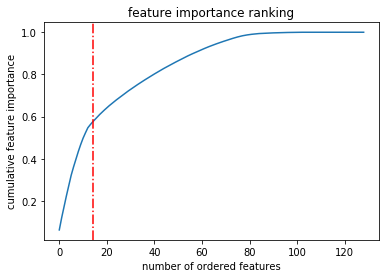

In [34]:
f_rank_cumsum = np.cumsum(np.array([x[1] for x in feature_rank]))
plt.plot(f_rank_cumsum)
plt.title("feature importance ranking")
plt.xlabel("number of ordered features")
plt.ylabel("cumulative feature importance")
plt.axvline(x=14, linestyle='-.', color='r')

The figure above shows that there is a obvious elbow at ```num_features = 14```. We will choose only the 14 first features for the next.

In [36]:
selected_features = [feat for feat, feat_imp in feature_rank[:14]]
print(selected_features)

['gaw20_score', 'degree_std', 'comb_absolute_value', 'lower_absolute_value', 'rw_absolute_value', 'upper_absolute_value', 'first_density', 'first_strength', 'second_density', 'second_strength', 'gaw10_score', 'NetEMD_lower_1', 'third_density', 'gaw_score']


We look into the 14 selected features and see which category they belongs to.

In [37]:
selected_features_categories = [features_categories[feat] for feat in selected_features]

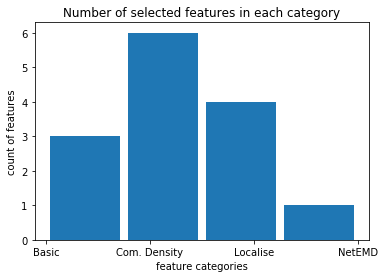

In [38]:
plt.figure()
plt.hist(selected_features_categories, bins=4, align='mid', rwidth=0.9)
plt.title("Number of selected features in each category")
plt.ylabel("count of features")
plt.xlabel("feature categories")
plt.show()

__Discussion__:

According to the figure above, we notice that The community detection category contributes most, while none path-based features are among the 14 most significant features.

### Train model on selected features

We then retrain the model on only the 14 selected features.

In [39]:
X_train = X_train.loc[:, selected_features]
X_test = X_test.loc[:, selected_features]

In [40]:
X_train.shape, X_test.shape

((9800, 14), (4200, 14))

In [42]:
print("n_est \t avrage precision")
for n_estimators in [10, 20, 50, 100, 150]:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_features='auto', n_jobs=-1)
    rf.fit(X_train, Y_train)
    pred_rf = rf.predict_proba(X_test)[:, 1]
    avg_prec = average_precision(pred_rf, Y_test)
    print(n_estimators, '\t', avg_prec)

n_est 	 avrage precision
10 	 0.5925221795844315
20 	 0.5993283025422856
50 	 0.6179840379730681
100 	 0.6154728697206063
150 	 0.6196862321764371


In [43]:
rf = RandomForestClassifier(n_estimators=50, max_features='auto', n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
pred_rf = rf.predict_proba(X_test)[:, 1]

sample_sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
precs, recs, f1 = precision_recall(pred_rf, Y_test, *sample_sizes)

In [47]:
print("Total number of samples: {}\n".format(len(Y_test)))
print("{}\t{}\t{}\t{}".format('samples', 'precision', 'recall', 'f1_score'))
print('-'*40)
for samples, prec, rec, f_1 in zip(sample_sizes, precs, recs, f1):
    print('{}\t{:.3f}\t\t{:.3f}\t{:.3f}'.format(samples, prec, rec, f_1))

Total number of samples: 4200

samples	precision	recall	f1_score
----------------------------------------
8	1.000		0.012	0.024
16	1.000		0.025	0.048
32	1.000		0.050	0.094
64	1.000		0.099	0.180
128	1.000		0.198	0.331
256	0.852		0.337	0.483
512	0.615		0.488	0.544
1024	0.393		0.622	0.481


In [48]:
avg_prec = average_precision(pred_rf, Y_test)
avg_prec

0.6104456330267676

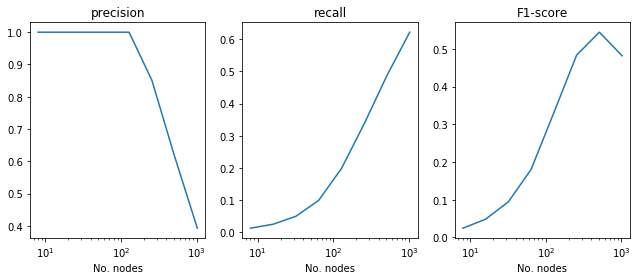

In [49]:
plt.figure(figsize=(9, 4))

plt.subplot(131)
plt.plot(sample_sizes, precs)
plt.xscale('log')
plt.title("precision")
plt.xlabel('No. nodes')

plt.subplot(132)
plt.plot(sample_sizes, recs)
plt.xscale('log')
plt.title("recall")
plt.xlabel('No. nodes')

plt.subplot(133)
plt.plot(sample_sizes, f1)
plt.xscale('log')
plt.title("F1-score")
plt.xlabel('No. nodes')

plt.tight_layout()

### Test on whole networks

Formerly, we mix all nodes of different networks together and split them for training and testing. In this section, we will try to train models on some networks and test them on some other networks. The testing networks are kept as a whole. Therefore, for each testing network, we perform the prediciton and evaluation precedure, and then average the performance metrics on all testing networks.

In [62]:
# select_features is no longer None, to use only the 14 seleceted features
# mix_all set to False
X_train, X_test, Y_train, Y_test = split_train_test(data, test_size=0.3, mix_all=False, select_features=selected_features)

In [63]:
X_train.shape, len(X_test)

((10000, 14), 4)

In [64]:
rf = RandomForestClassifier(n_estimators=50, max_features='auto', n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
sample_sizes = [8, 16, 32, 64, 128, 256, 512]
performance_measures = ['precision', 'recall', 'f1-score', 'avg-precision']
network_index = sorted(list(range(len(X_test)))*len(sample_sizes))
performance_matrix = pd.DataFrame(columns=performance_measures, index=[network_index, sample_sizes*len(X_test)], dtype=float)
performance_matrix.index.names= ['network_id', 'sample_size']

for network_id, (network, labels) in enumerate(zip(X_test, Y_test)):
    pred = rf.predict_proba(network)[:, 1]
    avg_prec = average_precision(pred, labels)
    precs, recs, f1s = precision_recall(pred, labels, *sample_sizes)
    for sample_size, prec, rec, f1 in zip(sample_sizes, precs, recs, f1s):
        performance_matrix.loc[(network_id, sample_size), 'precision'] = prec
        performance_matrix.loc[(network_id, sample_size), 'recall'] = rec
        performance_matrix.loc[(network_id, sample_size), 'f1-score'] = f1
        performance_matrix.loc[(network_id, sample_size), 'avg-precision'] = avg_prec
performance_matrix

precision    recall  f1-score  avg-precision
network_id sample_size                                              
0          8             1.000000  0.044199  0.084656       0.481427
           16            1.000000  0.088398  0.162437       0.481427
           32            1.000000  0.176796  0.300469       0.481427
           64            0.781250  0.276243  0.408163       0.481427
           128           0.484375  0.342541  0.401294       0.481427
           256           0.343750  0.486188  0.402746       0.481427
           512           0.250000  0.707182  0.369408       0.481427
1          8             0.875000  0.035714  0.068627       0.346755
           16            0.875000  0.071429  0.132075       0.346755
           32            0.843750  0.137755  0.236842       0.346755
           64            0.609375  0.198980  0.300000       0.346755
           128           0.398438  0.260204  0.314815       0.346755
           256           0.261719  0.341837  0.296460       0.346755
           512           0.203125  0.530612  0.293785       0.346755
2          8             1.000000  0.109589  0.197531       0.294683
           16            0.812500  0.178082  0.292135       0.294683
           32            0.500000  0.219178  0.304762       0.294683
           64            0.312500  0.273973  0.291971       0.294683
           128           0.187500  0.328767  0.238806       0.294683
           256           0.136719  0.479452  0.212766       0.294683
           512           0.097656  0.684932  0.170940       0.294683
3          8             1.000000  0.037736  0.072727       0.445910
           16            1.000000  0.075472  0.140351       0.445910
           32            0.968750  0.146226  0.254098       0.445910
           64            0.765625  0.231132  0.355072       0.445910
           128           0.531250  0.320755  0.400000       0.445910
           256           0.351562  0.424528  0.384615       0.445910
           512           0.228516  0.551887  0.323204       0.445910

In [66]:
average_performance = performance_matrix.groupby('sample_size').mean()
std_performance = performance_matrix.groupby('sample_size').std()
average_performance

,precision,recall,f1-score,avg-precision
sample_size,,,,
8,0.968750,0.056810,0.105885,0.392194
16,0.921875,0.103345,0.181749,0.392194
32,0.828125,0.169989,0.274043,0.392194
64,0.617188,0.245082,0.338802,0.392194
128,0.400391,0.313067,0.338729,0.392194
256,0.273438,0.433001,0.324147,0.392194
512,0.194824,0.618653,0.289335,0.392194


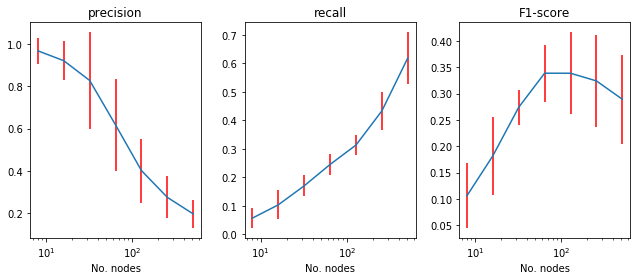

In [67]:
plt.figure(figsize=(9, 4))

plt.subplot(131)
plt.errorbar(sample_sizes, average_performance['precision'], yerr=std_performance['precision'], ecolor='r')
plt.xscale('log')
plt.title("precision")
plt.xlabel('No. nodes')

plt.subplot(132)
plt.errorbar(sample_sizes, average_performance['recall'], yerr=std_performance['recall'], ecolor='r')
plt.xscale('log')
plt.title("recall")
plt.xlabel('No. nodes')

plt.subplot(133)
plt.errorbar(sample_sizes, average_performance['f1-score'], yerr=std_performance['f1-score'], ecolor='r')
plt.xscale('log')
plt.title("F1-score")
plt.xlabel('No. nodes')

plt.tight_layout()